In [1]:
import json
import os

with open('vars.json') as f:
  data = json.load(f)

openai_api_key = data["open_ai_api_key"]
langchain_api_key = data["langchain_api_key"]
tavily_api_key = data["tavily_api_key"]
groq_api_key = data["groq_api_key"]

# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

In [2]:
# Setting up DB connection 
from langchain_community.utilities import SQLDatabase

# Docker command to run pgvector/postgres container
# docker run --name pgvector-container -e POSTGRES_USER=langchain -e POSTGRES_PASSWORD=langchain -e POSTGRES_DB=langchain -p 6024:5432 -d pgvector/pgvector:pg16
db_config = {
    'dbname': 'postgres',
    'user': 'langchain',
    'password': 'langchain',
    'host': 'localhost',
    'port': '6024'
}

connection_string = f"postgresql+psycopg://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"

db = SQLDatabase.from_uri(connection_string)
print(db.table_info)


CREATE TABLE customer (
	customer_id SERIAL NOT NULL, 
	name VARCHAR(100) NOT NULL, 
	CONSTRAINT customer_pkey PRIMARY KEY (customer_id)
)

/*
3 rows from customer table:
customer_id	name
1	John Doe
2	Jane Smith
3	Alice Johnson
*/


CREATE TABLE feedback (
	feedback_id SERIAL NOT NULL, 
	order_id INTEGER NOT NULL, 
	feedback_text TEXT, 
	CONSTRAINT feedback_pkey PRIMARY KEY (feedback_id), 
	CONSTRAINT feedback_order_id_fkey FOREIGN KEY(order_id) REFERENCES orders (order_id)
)

/*
3 rows from feedback table:
feedback_id	order_id	feedback_text
4	4	Pizza was average.
5	5	Pizza was average.
6	6	Pizza was average.
*/


CREATE TABLE orders (
	order_id SERIAL NOT NULL, 
	customer_id INTEGER NOT NULL, 
	preparation_time INTEGER NOT NULL, 
	order_date TIMESTAMP WITHOUT TIME ZONE DEFAULT CURRENT_TIMESTAMP, 
	CONSTRAINT orders_pkey PRIMARY KEY (order_id), 
	CONSTRAINT orders_customer_id_fkey FOREIGN KEY(customer_id) REFERENCES customer (customer_id)
)

/*
3 rows from orders table:
order_id	custo

In [3]:
# Define the LLM
from langchain_agents._models import get_llm

llm_llama3 = get_llm(llm_type='llama3', llm_model='llama3-70b-8192', api_key=groq_api_key)
llm_gpt = get_llm(llm_type='gpt', llm_model='gpt-3.5-turbo', api_key=openai_api_key)

In [4]:
# Step 1 :- Retrieve from SQL 
from langchain_core.prompts import ChatPromptTemplate

from langchain_agents._tool_calls import create_df_from_sql, python_shell
from langchain_agents._schemas import AgentState, RawToolMessage

retrive_from_db_prompt_string = f"""\
You are an expert at PostgreSQL and Python. You have access to a PostgreSQL database \
with the following tables

{db.table_info}

Given a user question related to the data in the database, \
first get the relevant data from the tables as a DataFrame using the create_df_from_sql tool"""

retrive_from_db_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", retrive_from_db_prompt_string),
        ("placeholder", "{messages}"),
    ]
)

def retrive_from_db_model_llama3(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    # print("-------------------------------------------------------")
    chain = retrive_from_db_prompt | llm_llama3.bind_tools([create_df_from_sql])
    messages.append(chain.invoke({"messages": state["messages"]}))
    # print(f"retrive_from_db_model_llama3 :- {messages}")
    # print("-------------------------------------------------------")

    return {"messages": messages}

In [5]:
# Step 2 :- Deciding future step according to the question 
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_agents._tool_calls import IsSemantic

is_semantic_prompt_string = f"""
You are a Data Analyst. You will be given a QUESTION.
You have to decide whether the question is releated to customer feedbacks.
"""

is_semantic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", is_semantic_prompt_string),
        ("human", "QUESTION: {question}"),
    ]
)

def decide_is_semantic_llama3(state: AgentState) -> dict:
    """Call model to decide weather the question is related to customer feedbacks"""
    messages = []

    chain = is_semantic_prompt | llm_llama3.with_structured_output(IsSemantic)
    question = state["messages"][-1].tool_calls[0]['args']['input_question']
    print(f"question :- {question}")
    messages.append(chain.invoke({"question": question}))
    print(f"is_semantic_model_llama3 :- {messages}")
    print("-------------------------------------------------------")

    return {"messages": messages}

In [6]:
def is_semantic(state: AgentState) -> str:
    return "analyze_feedbacks" if state["messages"][-1].binary_score == 1 else "generate_python_script"

In [7]:
# Branch 1. Step 1 :- Generating python code to answer the question
from langchain_agents._tool_calls import PythonScript

generate_python_script_prompt_string = f"""
You are a Python expert. 
You will be given a QUESTION, pandas dataframe name as DATAFRAME_NAME, column names of the dataframe as COLUMN_NAMES 
and the sql select QUERY used to get the dataframe. 
Using QUESTION, pandas DATAFRAME_NAME, COLUMN_NAMES of the dataframe and sql QUERY used to get the dataframe as reference 
Give a Python code to answer the QUESTION. Make sure to print any important results.
"""

generate_python_script_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", generate_python_script_prompt_string),
        ("human", "QUESTION: {question}, DATAFRAME_NAME: {dataframe_name}, COLUMN_NAMES: {column_names}, QUERY: {query}"),
    ]
)

def generate_python_script_llama3(state: AgentState) -> dict:
    messages = []

    chain = generate_python_script_prompt | llm_llama3.with_structured_output(PythonScript)
    
    question = state["messages"][-2].tool_calls[0]['args']['input_question']
    dataframe_name = state["messages"][-2].tool_calls[0]['args']['df_name']
    column_names = state["messages"][-2].tool_calls[0]['args']['df_columns']
    query = state["messages"][-2].tool_calls[0]['args']['select_query']

    messages.append(chain.invoke({
        "question": question,
        "dataframe_name": dataframe_name,
        "column_names": column_names,
        "query": query
    }))
    print("-------------------------------------------------------")

    return {"messages": messages}

In [8]:
# Branch 1. Step 2 :- Execute python code 
from langchain_agents._utils import execute_script, convert_python_result_to_msg_content
import pandas as pd

def upload_dfs_to_python_env(state: AgentState) -> str:
    df_name = state["messages"][-3].tool_calls[0]['args']['df_name']
    df_columns = state["messages"][-3].tool_calls[0]['args']['df_columns']
    select_query = state["messages"][-3].tool_calls[0]['args']['select_query']
    
    res = db.run(select_query, fetch="cursor").fetchall()
    df = pd.DataFrame(res, columns=df_columns)
    
    df_dir = ''
    df_path = f"{df_dir + df_name}" + '.csv'
    
    # Code for loading the uploaded files.
    df_code = "import pandas as pd\n" + "\n" + f"{df_name} = pd.read_csv('{df_path}')"
    return df_code
    

def execute_python_script(state: AgentState) -> dict:
    """
    Execute the latest generated Python code.
    """
    messages = []

    generated_code = state["messages"][-1].code
    
    if generated_code in [None, '']:
        return {"messages": messages}

    df_code = upload_dfs_to_python_env(state)

    print(f"Hard coded read df code :- \n{df_code}")
    print(f"AI generated_code :- \n{generated_code}")
    print("-------------------------------------------")

    python_result = execute_script(df_code + "\n" + generated_code)

    messages.append(
        RawToolMessage(
            convert_python_result_to_msg_content(python_result),
            raw=python_result,
            tool_call_id=state["messages"][-3].tool_calls[0]['id'],
            tool_name=state["messages"][-3].tool_calls[0]['name'],
        )
    )
    return {"messages": messages}

In [9]:
# Branch 2. Step 1 :- Analyze feedbacks 
from langchain_agents._tool_calls import FeedbackAnalysis

prompt = ChatPromptTemplate.from_template("Can you please give me a sentiment score for this customer feedback on a scale of 1 to 10, where 1 represents extremely negative sentiment and 10 represents extremely positive sentiment? {feedback}")

chain = prompt | llm_llama3.with_structured_output(schema=FeedbackAnalysis)

def analyze_feedbaks(state: AgentState) -> dict:
    results_list = []
    
    # TODO :- get feedbacks extract query from previous steps 
    select_query = "SELECT DISTINCT feedback_text FROM feedback"
    results = db.run(select_query, fetch="cursor").fetchall()
    for row in results:
        results_list.append({"feedback": row[0]})

    feedbacks_list = chain.batch(results_list)
    feedbacks_list = [x.__dict__ for x in feedbacks_list]
    for feedback in feedbacks_list:
        print(feedback)

    print("-------------------------------------------------------")

    return {"messages": []}

llama3 Agent :- 


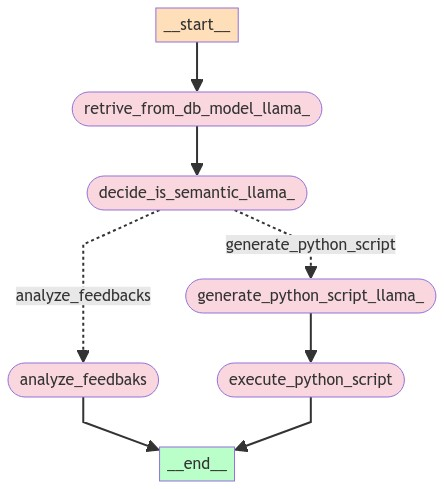

In [10]:
from langgraph.graph import END, StateGraph
from IPython.display import Image, display

workflow_llama3 = StateGraph(AgentState)

workflow_llama3.add_node("retrive_from_db_model_llama3", retrive_from_db_model_llama3)
workflow_llama3.add_node("decide_is_semantic_llama3", decide_is_semantic_llama3)
workflow_llama3.add_node("generate_python_script_llama3", generate_python_script_llama3)
workflow_llama3.add_node("execute_python_script", execute_python_script)
workflow_llama3.add_node("analyze_feedbaks", analyze_feedbaks)

workflow_llama3.set_entry_point("retrive_from_db_model_llama3")
workflow_llama3.add_edge("retrive_from_db_model_llama3", "decide_is_semantic_llama3")
workflow_llama3.add_conditional_edges(
    "decide_is_semantic_llama3",
    is_semantic,
    {
        "analyze_feedbacks": "analyze_feedbaks",
        "generate_python_script": "generate_python_script_llama3",
    },
)
workflow_llama3.add_edge("generate_python_script_llama3", "execute_python_script")
workflow_llama3.add_edge("execute_python_script", END)
workflow_llama3.add_edge("analyze_feedbaks", END)

app_llama3 = workflow_llama3.compile()
print("llama3 Agent :- ")
display(Image(app_llama3.get_graph().draw_mermaid_png()))

-------------------------------------------------------
question :- Graph the total number of orders of each customer
is_semantic_model_llama3 :- [IsSemantic(binary_score=0)]
-------------------------------------------------------
-------------------------------------------------------
Hard coded read df code :- 
import pandas as pd

orders_per_customer = pd.read_csv('orders_per_customer.csv')
AI generated_code :- 
import matplotlib.pyplot as plt
import pandas as pd

orders_per_customer.plot(kind='bar', x='customer_id', y='total_orders')
plt.title('Total Orders per Customer')
plt.xlabel('Customer ID')
plt.ylabel('Total Orders')
plt.show()
-------------------------------------------


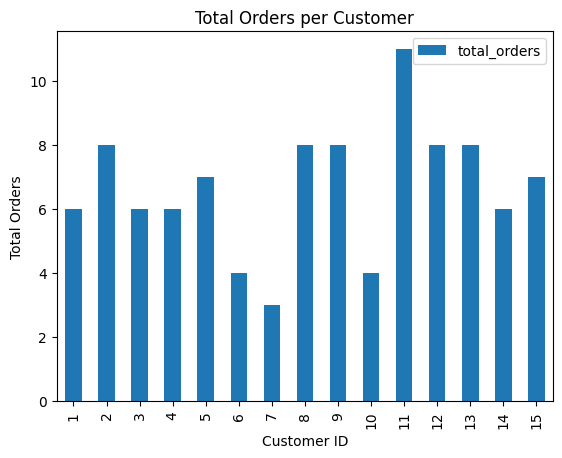

{
  "status": "success",
  "stdout": "",
  "stderr": ""
}


In [11]:
print("-------------------------------------------------------")
output_llama3 = app_llama3.invoke({"messages": [("human", "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.")]})
print(output_llama3["messages"][-1].content)

In [12]:
print("-------------------------------------------------------")
output_llama3 = app_llama3.invoke({"messages": [("human", "Give me a sentiment score for each feedback.")]})
print(output_llama3["messages"][-1])

-------------------------------------------------------
question :- Get feedback data
is_semantic_model_llama3 :- [IsSemantic(binary_score=1)]
-------------------------------------------------------
{'rating': 10, 'summary': 'Extremely positive sentiment due to excellent service, high-quality ingredients, and delightful ambiance.'}
{'rating': 10, 'summary': 'Delightful dining experience with excellent food and service'}
{'rating': 4, 'summary': 'Pizza was slightly undercooked'}
{'rating': 1, 'summary': 'Extremely negative sentiment due to uncleanliness, poor food quality, and bad service'}
{'rating': 5, 'summary': 'Average pizza'}
{'rating': 1, 'summary': 'Terrible dining experience with poor food quality and bad service'}
{'rating': 8, 'summary': 'Positive feedback about pizza'}
{'rating': 6, 'summary': 'Decent experience with average food and service'}
{'rating': 5, 'summary': 'Average dining experience with room for improvement'}
-----------------------------------------------------